In [1]:
import cv2
import os
#from google.colab.patches import cv2_imshow
import numpy as np
import random
import torch
print(torch.cuda.is_available())
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader, Subset
from torch.utils.data import random_split
import matplotlib.pyplot as plt

from sklearn.model_selection import KFold

False


In [2]:
TRAINPROP = 0.9
TESTPROP = 0.1
BATCHSIZE = 10
LEARNING_RATE = 0.001
MOMENTUM = 0.9
EPOCHS = 5
NUM_FOLDS = 5

In [3]:
#from google.colab import drive
#drive.mount('/content/drive')

In [4]:
folder_path = 'brain_scan/TCGA_HT_A616_19991226'

image_files = [f for f in os.listdir(folder_path) if f.endswith('mask.tif')] #noms des images
print("nombre d'images dans le dossier :", len(image_files))

sizes = []
k = 0
for file_name in image_files:
    k += 1
    file_path = os.path.join(folder_path, file_name)
    image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)

    sizes.append(image.shape)

    if k == 10 :
      break

print(sizes)


nombre d'images dans le dossier : 28
[(256, 256), (256, 256), (256, 256), (256, 256), (256, 256), (256, 256), (256, 256), (256, 256), (256, 256), (256, 256)]


brain_scan/TCGA_HT_A616_19991226\TCGA_HT_A616_19991226_15_mask.tif


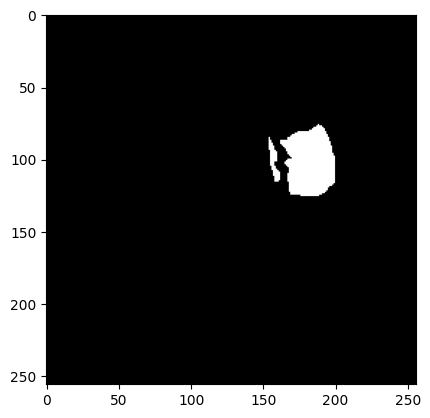

In [5]:
filename = image_files[5]
file_path = os.path.join(folder_path, filename)
image = cv2.imread(file_path,cv2.IMREAD_GRAYSCALE)
print(file_path)
plt.imshow(image, cmap='gray')


In [6]:
r = np.array(image[:,:])

print(np.max(r))
print(image.shape)
print(r.shape)

255
(256, 256)
(256, 256)


In [7]:
class CustomDataset(Dataset):
  def __init__(self):
    self.name = []
    self.folder_path = 'brain_scan/'
    for f1 in os.listdir(self.folder_path):
      if not (f1 == "data.csv" or f1 == "README.md"): #utiliser isdir()
        for f2 in os.listdir(os.path.join(self.folder_path,f1)):
          if f2.endswith('mask.tif'):
            self.name.append(os.path.join(f1,f2))

  def __len__(self):
    return len(self.name)

  def __getitem__(self,idx):
    self.mask = 1/255*cv2.imread(os.path.join(self.folder_path, self.name[idx]),cv2.IMREAD_GRAYSCALE)[:,:]
    self.image = 1/255*cv2.imread(os.path.join(self.folder_path, self.name[idx].replace("_mask.tif",".tif")),cv2.IMREAD_GRAYSCALE)[:,:]

    return (torch.tensor(self.image, dtype = torch.float).unsqueeze(0), torch.tensor(self.mask, dtype = torch.float).unsqueeze(0), self.name[idx])

In [8]:
dt = CustomDataset()

In [9]:
nb_N = 0
idx_P = []
idx_N = []
for idx in range(dt.__len__()):
    mask = dt.__getitem__(idx)[1]
    r = np.array(mask[:,:])
    if np.max(r) == 0:
        nb_N += 1
        idx_N.append(idx)
    else :
        idx_P.append(idx)

print(f'Proportion empty mask : {100*nb_N/dt.__len__():.2f}%' )



Proportion empty mask : 63.02%


In [10]:
#Delete some of the empty mask
list_idx = random.sample(idx_N, 300) + idx_P
#Create a subset dataset to equilibrate the dataset
equil_dt = Subset(dt, list_idx)

print(equil_dt.__len__())

939


In [11]:
train_ds, test_ds = random_split(equil_dt, [TRAINPROP, TESTPROP])

In [12]:
class Net(nn.Module) :
  def __init__(self) :
    super().__init__()

    dropout = 0.1

    self.conv1 = nn.Conv2d(1,32,3,padding='same')
    #self.conv1bis = nn.Conv2d(32,64,3,padding='same')
    self.bn1 = nn.BatchNorm2d(32)
    self.activ1 = nn.ReLU()
    self.pool1 = nn.MaxPool2d(2)
    self.dropout1 = nn.Dropout(p=dropout)
    self.conv2 = nn.Conv2d(32,64,3,padding='same')
    self.bn2 = nn.BatchNorm2d(64)
    self.activ2 = nn.ReLU()
    self.pool2 = nn.MaxPool2d(2)
    self.dropout2 = nn.Dropout(p=dropout)
    self.conv3 = nn.Conv2d(64,128,3,padding='same')
    self.bn3 = nn.BatchNorm2d(128)
    self.activ3 = nn.ReLU()
    self.pool3 = nn.MaxPool2d(2)
    self.dropout3 = nn.Dropout(p=dropout)
    self.conv4 = nn.Conv2d(128,256,3,padding='same')
    self.bn4 = nn.BatchNorm2d(256)
    self.activ4 = nn.ReLU()
    self.pool4 = nn.MaxPool2d(2)
    self.dropout4 = nn.Dropout(p=dropout)

    self.upsample1 = nn.Upsample(scale_factor = 2, mode ='bilinear', align_corners = True)
    self.conv5 = nn.ConvTranspose2d(256,128,3,padding='same')
    self.dropout5 = nn.Dropout(p=dropout)
    self.upsample2 = nn.Upsample(scale_factor = 2, mode ='bilinear', align_corners = True)
    self.conv6 = nn.ConvTranspose2d(128,64,3,padding='same')
    self.dropout6 = nn.Dropout(p=dropout)
    self.upsample3 = nn.Upsample(scale_factor = 2, mode ='bilinear', align_corners = True)
    self.conv7 = nn.ConvTranspose2d(64,32,3,padding='same')
    self.dropout7 = nn.Dropout(p=dropout)
    self.upsample4 = nn.Upsample(scale_factor = 2, mode ='bilinear', align_corners = True)
    self.conv8 = nn.ConvTranspose2d(32,1,3,padding='same')
    #self.conv8bis = nn.Conv2d(32,1,3,padding='same')
    self.dropout8 = nn.Dropout(p=dropout)

    self.sigmoid = nn.Sigmoid() #met les valeur entre 0 et 1

    self._initialize_weights()


  def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)


  def forward(self, x) : # dimension de x : (256,256), en général je met les dimensions en sortie de couche après la couche.
    
    x = self.conv1(x)
    #x = self.conv1bis(x)
    #taille 32,256,256
    x = self.bn1(x)
    x = self.activ1(x)
    x = self.pool1(x)
    #taille 32,128,128
    x = self.dropout1(x) 

    x = self.conv2(x)
    #taille 64,128,128
    x = self.bn2(x)
    x = self.activ2(x)
    x = self.pool2(x)
    #taille 64,64,64
    x = self.dropout2(x)

    x = self.conv3(x)
    #taille 128,64,64
    x = self.bn3(x)
    x = self.activ3(x)
    x = self.pool3(x)
    #taille 128,32,32
    x = self.dropout3(x)

    x = self.conv4(x)
    #taille 256,32,32
    x = self.bn4(x)
    x = self.activ4(x)
    x = self.pool4(x)
    #taille 256,16,16
    x = self.dropout4(x)


    x = self.upsample1(x)
    #taille 256,32,32
    x = self.conv5(x)
    x = self.dropout5(x)

    x = self.upsample2(x)
    #taille 128,64,64
    x = self.conv6(x)
    x = self.dropout6(x)

    x = self.upsample3(x)
    #taille 64,128,128
    x = self.conv7(x)
    x = self.dropout7(x)

    x = self.upsample4(x)
    #taille 32,256,256
    x = self.conv8(x)
    #x = self.conv8bis(x)
    x = self.dropout8(x)
    #taille 1,256,256

    x = self.sigmoid(x)

    return x # le squeeze enlève tous les 1 des dimensions

In [13]:
my_nn = Net().to('cuda' if torch.cuda.is_available() else 'cpu')
print(my_nn)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (activ1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.1, inplace=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (activ2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout2): Dropout(p=0.1, inplace=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (activ3): ReLU()
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout3): Dropout(p=0.1, inplace=False)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=

In [14]:
#On définit la Dice Loss
def dice_coefficient(y_true, y_pred, smooth=1):
    y_pred = (y_pred>0.5).float()
    intersection = torch.sum(y_true * y_pred)
    union = torch.sum(y_true) + torch.sum(y_pred)
    dice = (2. * intersection + smooth) / (union + smooth)
    return dice

'''def dice_coefficient(y_true, y_pred, smooth=1):
    batch_size = y_true.size(0)  # Get the batch size
    dice_total = 0
    
    for i in range(batch_size):
        # Binarize y_pred using a threshold of 0.5
        y_pred_i = (y_pred[i] > 0.5).float()
        
        # Calculate the intersection and union for each image
        intersection = torch.sum(y_true[i] * y_pred_i)
        union = torch.sum(y_true[i]) + torch.sum(y_pred_i)
        
        # Calculate the Dice coefficient for the current image
        dice = (2. * intersection + smooth) / (union + smooth)
        
        # Accumulate the Dice coefficient
        dice_total += dice
    
    # Return the average Dice coefficient for the batch
    return dice_total / batch_size'''

def total_loss(y_true, y_pred, smooth=1):
    loss = 1 - dice_coefficient(y_true, y_pred, smooth) + nn.BCELoss()(y_pred, y_true)
    return loss

In [15]:
criterion = total_loss

In [16]:
optimizer = optim.SGD(my_nn.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)
#optimizer = optim.Adam(my_nn.parameters(), lr=LEARNING_RATE)

In [17]:
# Initialize KFold
kf = KFold(n_splits=NUM_FOLDS)

Fold 1/5


Epoch 1/5, Loss: 1.59124 - Dice Coefficient : 0.3%: 100%|██████████| 22/22 [03:43<00:00, 10.16s/it]
Epoch 2/5, Loss: 1.08214 - Dice Coefficient : 12.0%: 100%|██████████| 22/22 [02:57<00:00,  8.07s/it]
Epoch 3/5, Loss: 0.98499 - Dice Coefficient : 15.5%: 100%|██████████| 22/22 [02:54<00:00,  7.91s/it]
Epoch 4/5, Loss: 0.97854 - Dice Coefficient : 15.6%: 100%|██████████| 22/22 [02:59<00:00,  8.18s/it]
Epoch 5/5, Loss: 0.94181 - Dice Coefficient : 18.8%: 100%|██████████| 22/22 [02:56<00:00,  8.03s/it]


Fold 1, Validation Loss: 1.07245 - Validation Dice Coefficient : 0.0%


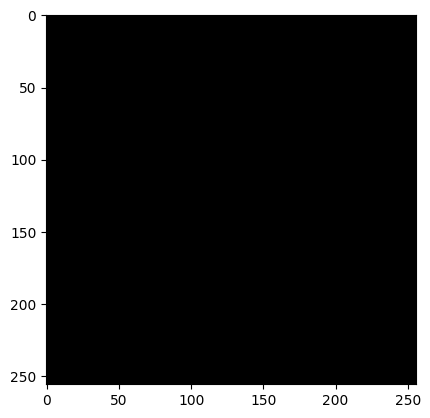

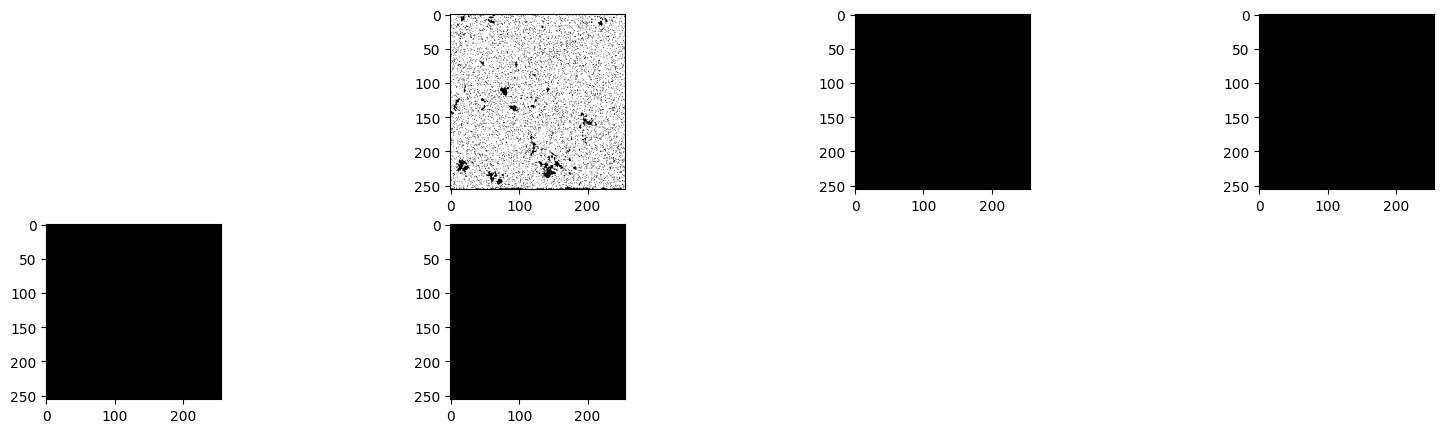

Fold 2/5


Epoch 1/5, Loss: 1.00594 - Dice Coefficient : 5.9%: 100%|██████████| 22/22 [02:41<00:00,  7.35s/it]
Epoch 2/5, Loss: 0.90789 - Dice Coefficient : 15.3%: 100%|██████████| 22/22 [02:37<00:00,  7.17s/it]
Epoch 3/5, Loss: 0.84310 - Dice Coefficient : 21.6%: 100%|██████████| 22/22 [02:38<00:00,  7.20s/it]
Epoch 4/5, Loss: 0.84395 - Dice Coefficient : 21.4%: 100%|██████████| 22/22 [02:36<00:00,  7.13s/it]
Epoch 5/5, Loss: 0.82050 - Dice Coefficient : 23.8%: 100%|██████████| 22/22 [02:35<00:00,  7.07s/it]


Fold 2, Validation Loss: 0.95360 - Validation Dice Coefficient : 11.9%


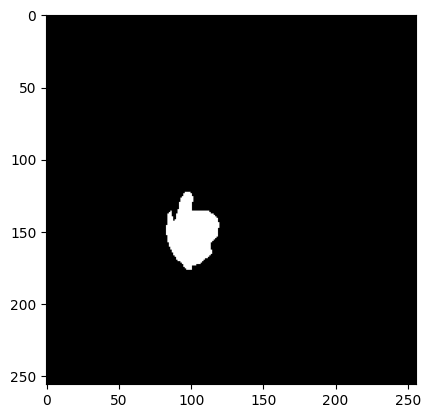

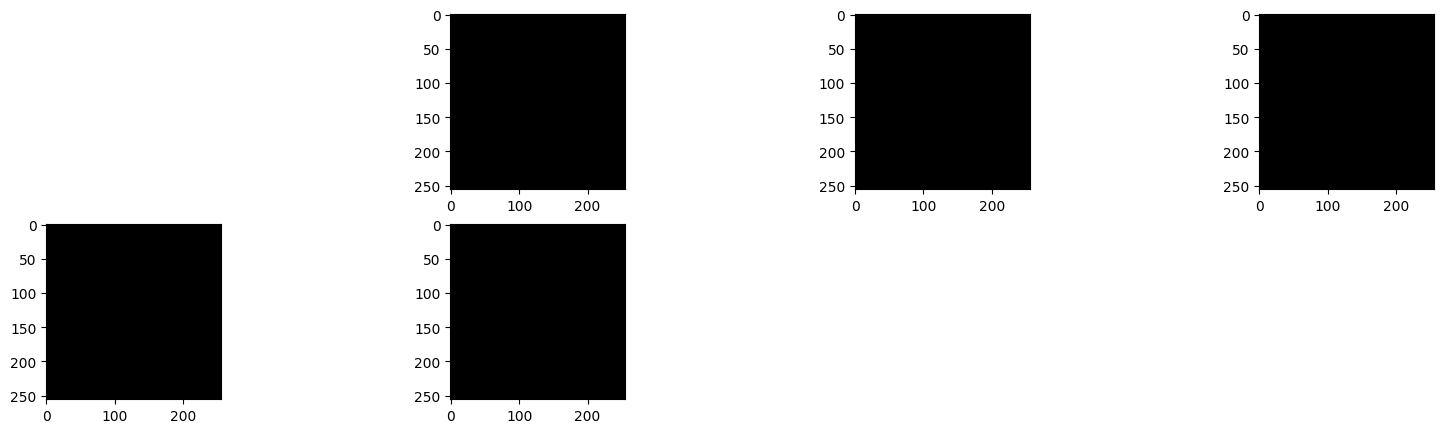

Fold 3/5


Epoch 1/5, Loss: 0.80674 - Dice Coefficient : 25.3%: 100%|██████████| 22/22 [02:39<00:00,  7.26s/it]
Epoch 2/5, Loss: 0.76982 - Dice Coefficient : 28.8%: 100%|██████████| 22/22 [02:36<00:00,  7.11s/it]
Epoch 3/5, Loss: 0.70770 - Dice Coefficient : 34.9%: 100%|██████████| 22/22 [02:35<00:00,  7.05s/it]
Epoch 4/5, Loss: 0.73356 - Dice Coefficient : 32.3%: 100%|██████████| 22/22 [02:36<00:00,  7.09s/it]
Epoch 5/5, Loss: 0.68853 - Dice Coefficient : 36.8%: 100%|██████████| 22/22 [02:34<00:00,  7.02s/it]


Fold 3, Validation Loss: 0.72333 - Validation Dice Coefficient : 32.5%


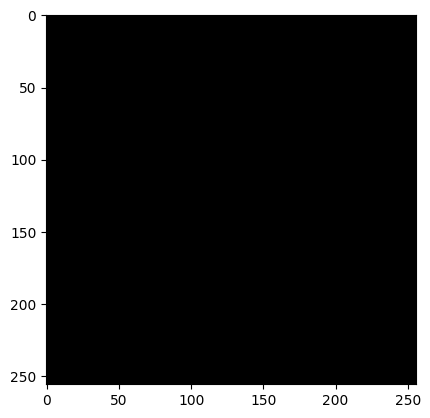

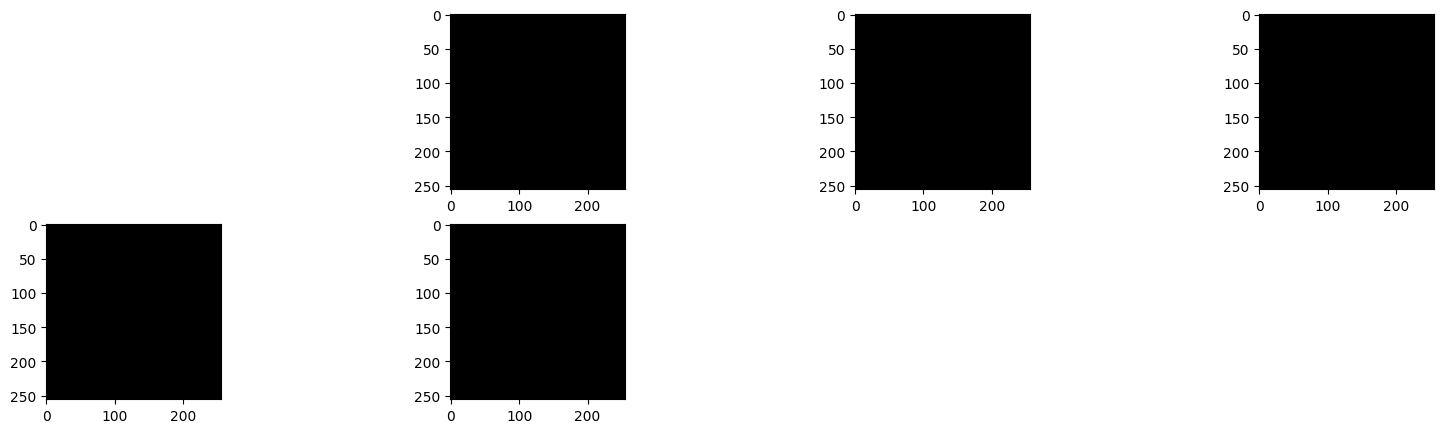

Fold 4/5


Epoch 1/5, Loss: 0.70663 - Dice Coefficient : 34.9%: 100%|██████████| 22/22 [02:40<00:00,  7.30s/it]
Epoch 2/5, Loss: 0.69892 - Dice Coefficient : 35.4%: 100%|██████████| 22/22 [02:37<00:00,  7.15s/it]
Epoch 3/5, Loss: 0.70001 - Dice Coefficient : 35.3%: 100%|██████████| 22/22 [02:38<00:00,  7.19s/it]
Epoch 4/5, Loss: 0.67907 - Dice Coefficient : 37.4%: 100%|██████████| 22/22 [02:36<00:00,  7.11s/it]
Epoch 5/5, Loss: 0.69264 - Dice Coefficient : 36.1%: 100%|██████████| 22/22 [02:34<00:00,  7.03s/it]


Fold 4, Validation Loss: 0.63167 - Validation Dice Coefficient : 42.2%


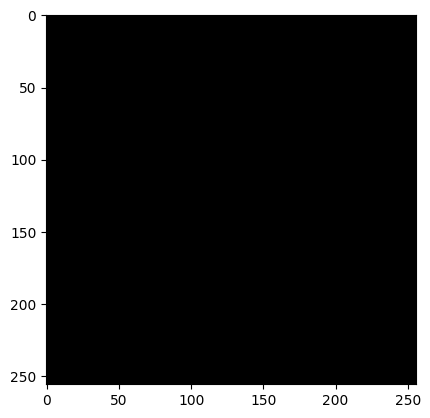

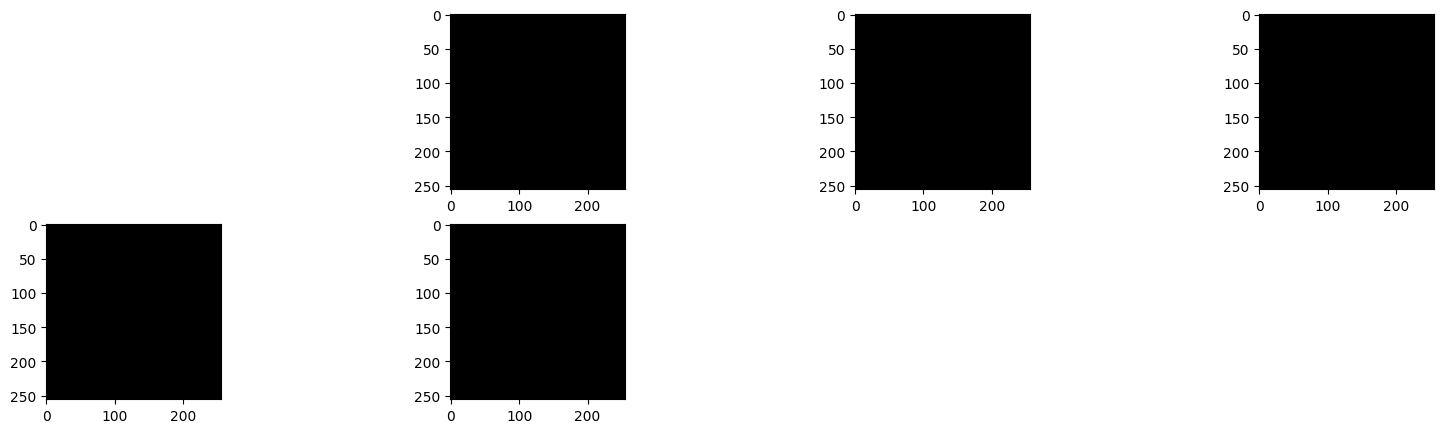

Fold 5/5


Epoch 1/5, Loss: 0.68457 - Dice Coefficient : 37.0%: 100%|██████████| 22/22 [02:36<00:00,  7.11s/it]
Epoch 2/5, Loss: 0.67055 - Dice Coefficient : 38.3%: 100%|██████████| 22/22 [02:37<00:00,  7.16s/it]
Epoch 3/5, Loss: 0.67557 - Dice Coefficient : 37.8%: 100%|██████████| 22/22 [02:36<00:00,  7.13s/it]
Epoch 4/5, Loss: 0.62488 - Dice Coefficient : 42.6%: 100%|██████████| 22/22 [02:35<00:00,  7.09s/it]
Epoch 5/5, Loss: 0.65746 - Dice Coefficient : 39.3%: 100%|██████████| 22/22 [02:35<00:00,  7.08s/it]


Fold 5, Validation Loss: 0.60250 - Validation Dice Coefficient : 44.4%


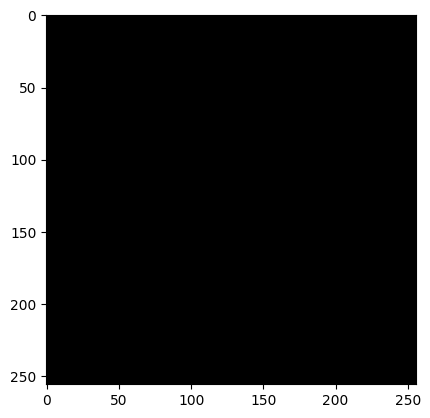

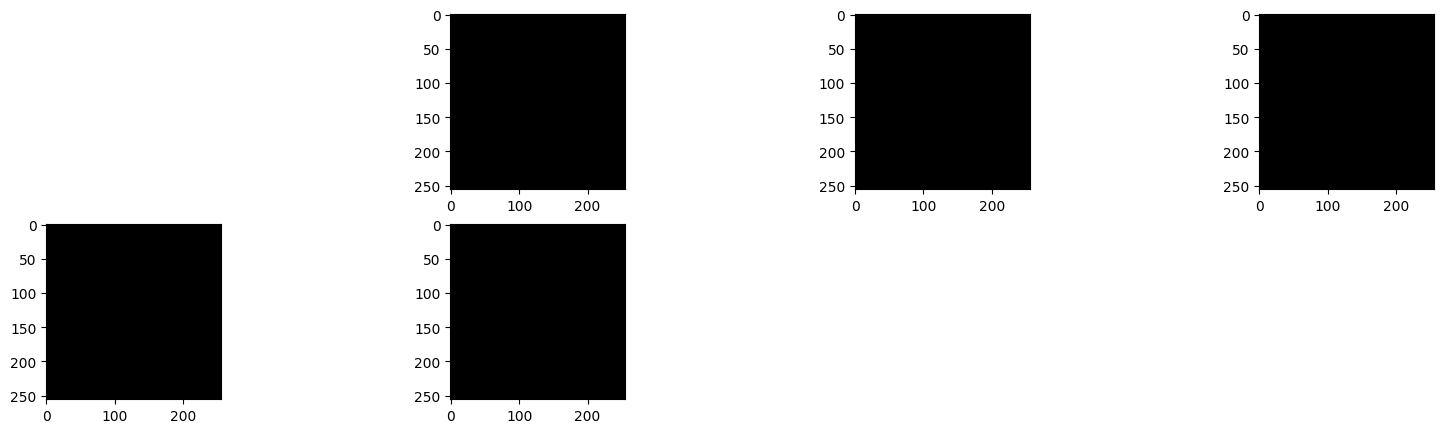

Training finished


In [18]:
for fold, (train_index, val_index) in enumerate(kf.split(train_ds)):
    visu = []
    ref_name = ''
    name_saved = False  # Flag to check if the label has been saved
    print(f'Fold {fold + 1}/{NUM_FOLDS}')

    # Sample elements randomly from a given list of indices, no replacement.
    train_subsampler = Subset(train_ds, train_index)
    val_subsampler = Subset(train_ds, val_index)

    # Define data loaders for training and validation
    train_dl = DataLoader(train_subsampler, batch_size=BATCHSIZE, shuffle=True)
    val_dl = DataLoader(val_subsampler, batch_size=BATCHSIZE, shuffle=True)

    for epoch in range(EPOCHS):

        running_loss = 0.0
        running_dice_coeff = []
        dataloader = tqdm(train_dl, position=0, leave=True)

        for inputs, labels, name in dataloader:

        
            optimizer.zero_grad()
            outputs = my_nn(inputs)

            loss = criterion(labels, outputs)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            running_dice_coeff.append(dice_coefficient(labels, outputs).item())
            
            
            if not name_saved :
                ref_name = name[0]
                name_saved = True

            for idx in range(len(inputs)):
                #Visualisation of progress with one image
                if ref_name == name[idx]:
                    if not visu:
                        visu.append(labels[idx])
                    visu.append((outputs[idx]> 0.5).float())

            dataloader.set_description(f'Epoch {epoch + 1}/{EPOCHS}, Loss: {running_loss / len(train_dl):.5f} - Dice Coefficient : {100*sum(running_dice_coeff)/len(running_dice_coeff):.1f}%')
            dataloader.refresh()
        
        dataloader.close()

    # Validation phase
    my_nn.eval()
    val_loss = 0.0
    val_dice_coeff = []
    with torch.no_grad():
        for val_inputs, val_labels, name in val_dl:

            val_outputs = my_nn(val_inputs)

            val_loss += criterion(val_labels, val_outputs).item()
            val_dice_coeff.append(dice_coefficient(val_labels, val_outputs).item())

    print(f'Fold {fold + 1}, Validation Loss: {val_loss / len(val_dl):.5f} - Validation Dice Coefficient : {100*sum(val_dice_coeff)/len(val_dice_coeff):.1f}%')
    
    
    plt.imshow(visu[0][0,:, :].cpu().detach().numpy(), cmap='gray')
    plt.figure(figsize=(20, 5))
    for i in range(1,len(visu)):
        plt.subplot(2, int(len(visu)/2 +1), i+1, label = f'Epoch {i+1}/{len(visu)}')
        plt.imshow(visu[i][0,:, :].cpu().detach().numpy(), cmap='gray') 
    plt.show()


print('Training finished')

In [23]:
test_dl = DataLoader(test_ds, batch_size=BATCHSIZE, shuffle=True)

0.3298065960407257
0.42550572752952576
0.3371935188770294
0.23872067034244537
0.3282548189163208


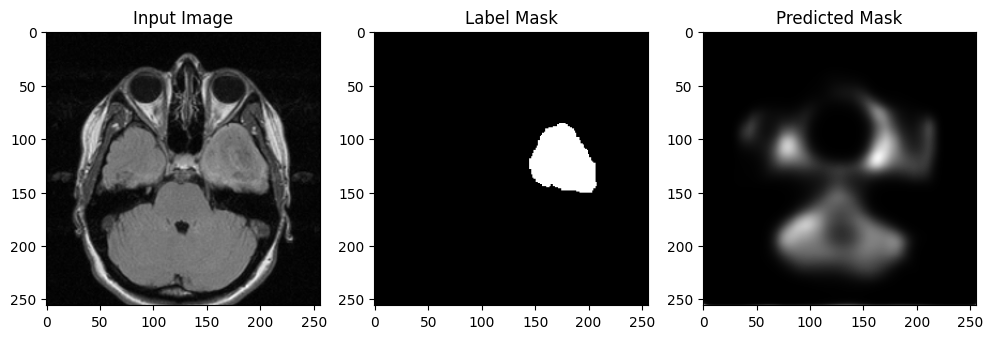

0.3376253545284271
0.5123807787895203
0.2812207043170929
0.22617828845977783
0.3737304210662842


In [29]:
my_nn.eval()  # Mise en mode évaluation (pour éviter des calculs inutiles pendant l'évaluation)
k = 0
for inputs, labels , name in test_dl:
    outputs = my_nn(inputs)

    print(dice_coefficient(outputs, labels).item())

    # Si k est égal à zéro, alors plot les premières images
    if k == 4:
        # Convertir les tensors PyTorch en tableaux NumPy pour Matplotlib
        input_image = inputs[0, 0, :, :].cpu().numpy()
        label_mask = labels[0, 0, :, :].cpu().numpy()
        predicted_mask = torch.sigmoid(outputs[0, 0, :, :]).detach().cpu().numpy()  # Appliquer la sigmoïde aux prédictions

        # Plot des images
        plt.figure(figsize=(12, 4))

        plt.subplot(1, 3, 1)
        plt.imshow(input_image, cmap='gray')
        plt.title('Input Image')

        plt.subplot(1, 3, 2)
        plt.imshow(label_mask, cmap='gray')
        plt.title('Label Mask')

        plt.subplot(1, 3, 3)
        plt.imshow(predicted_mask, cmap='gray')
        plt.title('Predicted Mask')

        plt.show()

    k += 1


dataloader.close()